# Reading files

In [1]:
import os
from typing import List

def list_files_in_directory(directory_path: str) -> List[str]:
    """
    Retrieves all files within a specified directory.

    Args:
        directory_path (str): Path to the target directory.

    Returns:
        List[str]: A list of file paths found in the directory.
    """
    files = []
    for root, _, filenames in os.walk(directory_path):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    return files

In [ ]:
import numpy as np
import pandas as pd

# Dataset path
dataset_path = "dataset-fatigate"

# All files from dataset
files = sorted(list_files_in_directory(dataset_path))

# List to store time series data
X = []
y = None

# Load each file, ignoring the first column and treating the second as a string
for file in files:
    # Using pandas to read the CSV file
    data = pd.read_csv(file, header=None)  # No header

    # Drop the first column, take the second as y, and the rest as time series data
    if y is None:
        y = data.iloc[:, 1].astype(str)  # Take the second column as string
    X.append(data.iloc[:, 2:].values.astype(float))  # Time series columns starting from the third column

# Convert the list of series to a 3D array with shape (n_instances, n_series, size_series)
X = np.stack(X, axis=1)
y = y.values


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def extract_filenames(file_paths: List[str]) -> List[str]:
    """
    Extracts the filename without extension from each path in a list of file paths.
    
    Args:
        file_paths (List[str]): List of file paths.
        
    Returns:
        List[str]: List of filenames without the directory and file extension.
    
    Example:
        >>> file_paths = [
        ...     'dataset-fatigate/Accel_X_all.csv',
        ...     'dataset-fatigate/Accel_Y_all.csv'
        ... ]
        >>> extract_filenames(file_paths)
        ['Accel_X', 'Accel_Y']
    """
    return [os.path.splitext(os.path.basename(path))[0][:-4] for path in file_paths]

def plot_instance_series(X: np.ndarray, y: np.ndarray, column_names: List[str], instance_index: int, dpi: int = 1200) -> None:
    """
    Plots all series for a single instance in a 3x3 grid of subplots.

    Args:
        X (np.ndarray): 3D array of shape (n_instances, n_series, size_series) containing the time series data.
        y (np.ndarray): 1D array of shape (n_instances,) containing the label for each instance.
        column_names (List[str]): List of column names for each time series.
        instance_index (int): Index of the instance to plot.
        dpi (int): Dots per inch (DPI) for the figure resolution. Default is 100.
        
    Raises:
        ValueError: If the instance_index is out of bounds for the array X.
    """
    if instance_index < 0 or instance_index >= X.shape[0]:
        raise ValueError("Instance index out of bounds.")
    
    n_series = X.shape[1]
    fig, axes = plt.subplots(3, 3, figsize=(15, 10), dpi=dpi)  # Set DPI here
    
    # Main title with the instance label
    fig.suptitle(f'Instance {instance_index} - Label: {y[instance_index]}', fontsize=16)
    
    # Plot each series in a separate subplot
    for i in range(n_series):
        row, col = divmod(i, 3)
        axes[row, col].plot(X[instance_index, i])
        axes[row, col].set_title(column_names[i] if i < len(column_names) else f'Series {i + 1}')
        axes[row, col].set_xlabel('Time')
        axes[row, col].set_ylabel('Value')
    
    # Hide the 9th subplot if n_series < 9
    if n_series < 9:
        fig.delaxes(axes[2, 2])

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title
    plt.show()

columns_names = extract_filenames(files)
plot_instance_series(X, y, columns_names, 0)
plot_instance_series(X, y, columns_names, len(X) - 1)

# Classification

In [ ]:
from aeon.transformations.collection.convolution_based import Rocket
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pandas as pd

# Defining some constants
cv = 5
random_state = 42
n_jobs = -1

# Define the list of metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Defining the RidgeClassifier with a fixed alpha
classifier = RidgeClassifier(random_state=random_state)

# Defining the parameter space for Rocket (varying num_kernels)
param_grid = {
    'rocket__num_kernels': [50, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],  # Values of num_kernels to test
    'ridge__alpha': [1.0, 10.0, 100.0]
}

# Defining the pipeline with Rocket and RidgeClassifier
model = Pipeline([
    ('rocket', Rocket(random_state=random_state)),  # Rocket transformation
    ('ridge', classifier)  # Ridge classifier
])

# Setting up GridSearchCV to tune num_kernels
grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1",  # Focusing on optimizing the f1-score
    cv=cv,
    n_jobs=n_jobs,
    verbose=1  # Enables detailed output about the search process
)

# Running GridSearchCV (replace X and y with your actual data)
grid_search.fit(X, y)

# Saving the results
df_results = pd.DataFrame(grid_search.cv_results_)
df_results.to_csv("results/results_ridge_rocket_gridsearch.csv", index=False)

print("Results saved for RidgeClassifier with Rocket using GridSearchCV.")


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/matheus/Desktop/Itens/Faculdade/1 semestre/series temporais/trabalho 2/time-series/lib/python3.12/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(
/home/matheus/Desktop/Itens/Faculdade/1 semestre/series temporais/trabalho 2/time-series/lib/python3.12/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' 

Results saved for RidgeClassifier with Rocket using GridSearchCV.


# Show Results

In [33]:
df_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.653716      0.343727         0.581640        0.081575   
1       20.466778      0.806014         5.133961        0.236750   
2       41.289603      1.114131        10.431082        0.352414   
3      100.133576      6.110828        24.948318        1.691665   
4      160.097568      5.375716        41.784069        2.987478   
5      221.901894      7.248472        54.482581        3.152103   
6      287.042474      4.917533        69.200834        1.645740   
7      343.953592      5.279639        83.064190        4.721180   
8      419.413621     10.475023        96.863258        4.580840   
9      476.359346      5.788205       115.840678        3.644913   
10     532.246185     10.377456       125.960302        3.322662   
11     610.030480      8.317072       143.502680        6.748138   
12       3.658970      1.536068         0.781672        0.435294   
13      31.960062      1.350967         5.608503        0.086962   
14      55.633597      3.328063        12.547613        1.958018   
15     123.393770      5.849092        29.167111        2.681441   
16     186.528841      5.565303        42.091539        1.037102   
17     239.017464      7.607416        54.740139        3.193369   
18     303.450665      3.745140        70.857585        1.840610   
19     358.651002      9.868568        85.562090        2.904770   
20     434.722940      5.151445       106.786751        4.966769   
21     499.101737     10.174908       123.697911        5.310716   
22     575.603293      5.756851       134.742834        3.229609   
23     648.171450      8.278937       153.254495        4.538956   
24       3.838081      0.730651         0.968562        0.144427   
25      34.255419      1.467523         5.912923        0.605071   
26      64.459193      5.649353        14.142570        4.360379   
27     133.070974      6.096760        30.149925        2.362778   
28     194.263574      5.539035        45.674293        5.497515   
29     254.216767      6.529713        61.605145        3.641595   
30     314.409346      7.428994        68.226471        1.461795   
31     360.458676      9.607752        81.197839        4.998076   
32     404.409280      7.431833        94.500032        2.866383   
33     464.407320      4.997028       104.179115        6.134300   
34     479.551435     32.216642        88.853798       15.799026   
35     423.453428     35.521860        52.817991        5.532845   

   param_ridge__alpha param_rocket__num_kernels  \
0                 1.0                        50   
1                 1.0                       500   
2                 1.0                      1000   
3                 1.0                      2000   
4                 1.0                      3000   
5                 1.0                      4000   
6                 1.0                      5000   
7                 1.0                      6000   
8                 1.0                      7000   
9                 1.0                      8000   
10                1.0                      9000   
11                1.0                     10000   
12               10.0                        50   
13               10.0                       500   
14               10.0                      1000   
15               10.0                      2000   
16               10.0                      3000   
17               10.0                      4000   
18               10.0                      5000   
19               10.0                      6000   
20               10.0                      7000   
21               10.0                      8000   
22               10.0                      9000   
23               10.0                     10000   
24              100.0                        50   
25              100.0                       500   
26              100.0                      1000   
27              100.0                      2000   
28      

In [ ]:
df_filtered = df_results.copy()

# Rename columns to more readable names
rename_mapping = {
    'param_ridge__alpha': 'Ridge Alpha',
    'param_rocket__num_kernels': 'Rocket Kernels',
    'mean_test_accuracy': 'Accuracy (Mean)',
    'std_test_accuracy': 'Accuracy (Std)',
    'mean_test_recall': 'Recall (Mean)',
    'std_test_recall': 'Recall (Std)',
    'mean_test_precision': 'Precision (Mean)',
    'std_test_precision': 'Precision (Std)',
    'mean_test_f1': 'F1-Score (Mean)',
    'std_test_f1': 'F1-Score (Std)',
    'mean_fit_time': 'Fit Time (Mean)',
    'std_fit_time': 'Fit Time (Std)'
}

df_filtered = df_filtered.rename(columns=rename_mapping)
df_filtered = df_filtered.sort_values(by = "F1-Score (Mean)", ascending = False)

# Format metrics in "mean ± std" format
for metric in ['Accuracy', 'Recall', 'Precision', 'F1-Score', 'Fit Time']:
    mean_col = f"{metric} (Mean)"
    std_col = f"{metric} (Std)"
    if mean_col in df_filtered.columns and std_col in df_filtered.columns:
        df_filtered[metric] = (
            df_filtered[mean_col].round(3).astype(str) + 
            " ± " + 
            df_filtered[std_col].round(3).astype(str)
        )
        # Remove intermediate columns after formatting
        df_filtered.drop([mean_col, std_col], axis=1, inplace=True)

# Rearrange the columns
df_filtered = df_filtered[['Ridge Alpha', 'Rocket Kernels', 'Accuracy', 'Recall', 'Precision', 'F1-Score', 'Fit Time']]


display(df_filtered)

df_filtered.to_csv("results/formatted_results.csv", index=False)


Ridge Alpha  Rocket Kernels       Accuracy         Recall      Precision  \
0           1.0              50   0.704 ± 0.06   0.704 ± 0.06  0.728 ± 0.061   
12         10.0              50  0.668 ± 0.071  0.668 ± 0.071  0.698 ± 0.074   
15         10.0            2000  0.658 ± 0.081  0.658 ± 0.081  0.668 ± 0.085   
1           1.0             500  0.655 ± 0.073  0.655 ± 0.073  0.663 ± 0.074   
26        100.0            1000   0.65 ± 0.074   0.65 ± 0.074  0.655 ± 0.075   
27        100.0            2000  0.651 ± 0.085  0.651 ± 0.085  0.663 ± 0.089   
3           1.0            2000  0.641 ± 0.078  0.641 ± 0.078  0.647 ± 0.082   
30        100.0            5000   0.64 ± 0.082   0.64 ± 0.082  0.646 ± 0.085   
14         10.0            1000  0.641 ± 0.068  0.641 ± 0.068  0.648 ± 0.067   
13         10.0             500  0.638 ± 0.085  0.638 ± 0.085  0.644 ± 0.085   
33        100.0            8000  0.642 ± 0.095  0.642 ± 0.095  0.666 ± 0.093   
4           1.0            3000  0.636 ± 0.072  0.636 ± 0.072   0.651 ± 0.07   
2           1.0            1000  0.631 ± 0.058  0.631 ± 0.058  0.642 ± 0.059   
21         10.0            8000  0.637 ± 0.088  0.637 ± 0.088  0.658 ± 0.082   
9           1.0            8000  0.636 ± 0.089  0.636 ± 0.089  0.656 ± 0.082   
29        100.0            4000  0.622 ± 0.069  0.622 ± 0.069  0.627 ± 0.072   
28        100.0            3000  0.631 ± 0.081  0.631 ± 0.081  0.651 ± 0.082   
10          1.0            9000  0.626 ± 0.103  0.626 ± 0.103  0.633 ± 0.101   
22         10.0            9000  0.626 ± 0.105  0.626 ± 0.105  0.632 ± 0.103   
25        100.0             500   0.62 ± 0.096   0.62 ± 0.096  0.624 ± 0.096   
16         10.0            3000  0.627 ± 0.073  0.627 ± 0.073  0.644 ± 0.073   
5           1.0            4000  0.617 ± 0.054  0.617 ± 0.054  0.621 ± 0.056   
8           1.0            7000  0.624 ± 0.102  0.624 ± 0.102  0.635 ± 0.102   
18         10.0            5000  0.616 ± 0.068  0.616 ± 0.068    0.62 ± 0.07   
17         10.0            4000  0.614 ± 0.054  0.614 ± 0.054  0.619 ± 0.057   
20         10.0            7000  0.621 ± 0.105  0.621 ± 0.105  0.633 ± 0.105   
34        100.0            9000   0.62 ± 0.115   0.62 ± 0.115  0.627 ± 0.113   
32        100.0            7000  0.618 ± 0.114  0.618 ± 0.114  0.629 ± 0.113   
31        100.0            6000  0.603 ± 0.076  0.603 ± 0.076  0.607 ± 0.076   
24        100.0              50  0.613 ± 0.079  0.613 ± 0.079  0.639 ± 0.091   
19         10.0            6000  0.593 ± 0.047  0.593 ± 0.047  0.595 ± 0.049   
6           1.0            5000  0.591 ± 0.061  0.591 ± 0.061  0.594 ± 0.063   
11          1.0           10000  0.601 ± 0.072  0.601 ± 0.072   0.613 ± 0.07   
35        100.0           10000  0.601 ± 0.077  0.601 ± 0.077  0.613 ± 0.075   
23         10.0           10000  0.601 ± 0.073  0.601 ± 0.073  0.612 ± 0.071   
7           1.0            6000  0.584 ± 0.043  0.584 ± 0.043  0.586 ± 0.045   

         F1-Score          Fit Time  
0   0.695 ± 0.063     2.654 ± 0.344  
12  0.654 ± 0.075     3.659 ± 1.536  
15  0.653 ± 0.082   123.394 ± 5.849  
1   0.651 ± 0.075    20.467 ± 0.806  
26  0.646 ± 0.076    64.459 ± 5.649  
27  0.646 ± 0.087   133.071 ± 6.097  
3   0.638 ± 0.079   100.134 ± 6.111  
30  0.637 ± 0.083   314.409 ± 7.429  
14  0.636 ± 0.071    55.634 ± 3.328  
13  0.633 ± 0.087     31.96 ± 1.351  
33  0.627 ± 0.101   464.407 ± 4.997  
4   0.626 ± 0.078   160.098 ± 5.376  
2   0.624 ± 0.061     41.29 ± 1.114  
21  0.622 ± 0.096  499.102 ± 10.175  
9   0.621 ± 0.097   476.359 ± 5.788  
29  0.619 ± 0.069    254.217 ± 6.53  
28  0.617 ± 0.088   194.264 ± 5.539  
10  0.617 ± 0.107  532.246 ± 10.377  
22  0.617 ± 0.109   575.603 ± 5.757  
25  0.616 ± 0.097    34.255 ± 1.468  
16   0.615 ± 0.08   186.529 ± 5.565  
5   0.614 ± 0.053   221.902 ± 7.248  
8   0.614 ± 0.105  419.414 ± 10.475  
18  0.613 ± 0.069   303.451 ± 3.745  
17  0.612 ± 0.052   239.017 ± 7.607  
20  0.611 ± 0.108   434.723 ± 5.151  
34  0.611 ± 0.119

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_line_chart(data, x_col, y_col, hue_col, title=None, xlabel=None, ylabel=None, legend_title=None, figsize=(14, 8), palette="tab20", rotation=45):
    """
    Plots a line chart with options for customization.
    
    Parameters:
    - data (pd.DataFrame): The dataset containing the data to plot.
    - x_col (str): The column name for the x-axis values.
    - y_col (str): The column name for the y-axis values.
    - hue_col (str): The column name for the hue (categorical groups).
    - title (str, optional): Title of the plot.
    - xlabel (str, optional): Label for the x-axis.
    - ylabel (str, optional): Label for the y-axis.
    - legend_title (str, optional): Title for the legend.
    - figsize (tuple, optional): Size of the figure (width, height).
    - palette (str or list, optional): Color palette for the lines.
    - rotation (int, optional): Rotation angle for x-axis labels.
    
    Returns:
    - None: Displays the plot.
    """
    # Set style
    sns.set(style="whitegrid")
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Define palette
    unique_hue_values = data[hue_col].nunique()
    palette = sns.color_palette(palette, n_colors=unique_hue_values)
    
    # Plot the line chart
    sns.lineplot(data=data, x=x_col, y=y_col, hue=hue_col, marker='o', palette=palette)
    
    # Add titles and labels
    if title:
        plt.title(title, fontsize=14)
    if xlabel:
        plt.xlabel(xlabel, fontsize=12)
    if ylabel:
        plt.ylabel(ylabel, fontsize=12)
    
    # Customize x-axis ticks
    plt.xticks(data[x_col].unique(), rotation=rotation)
    
    # Add legend
    if legend_title:
        plt.legend(title=legend_title)
    else:
        plt.legend(title=hue_col)
    
    # Show plot
    plt.tight_layout()
    plt.show()


In [37]:
df_results = pd.read_csv("results/results_ridge_rocket_gridsearch2.csv")

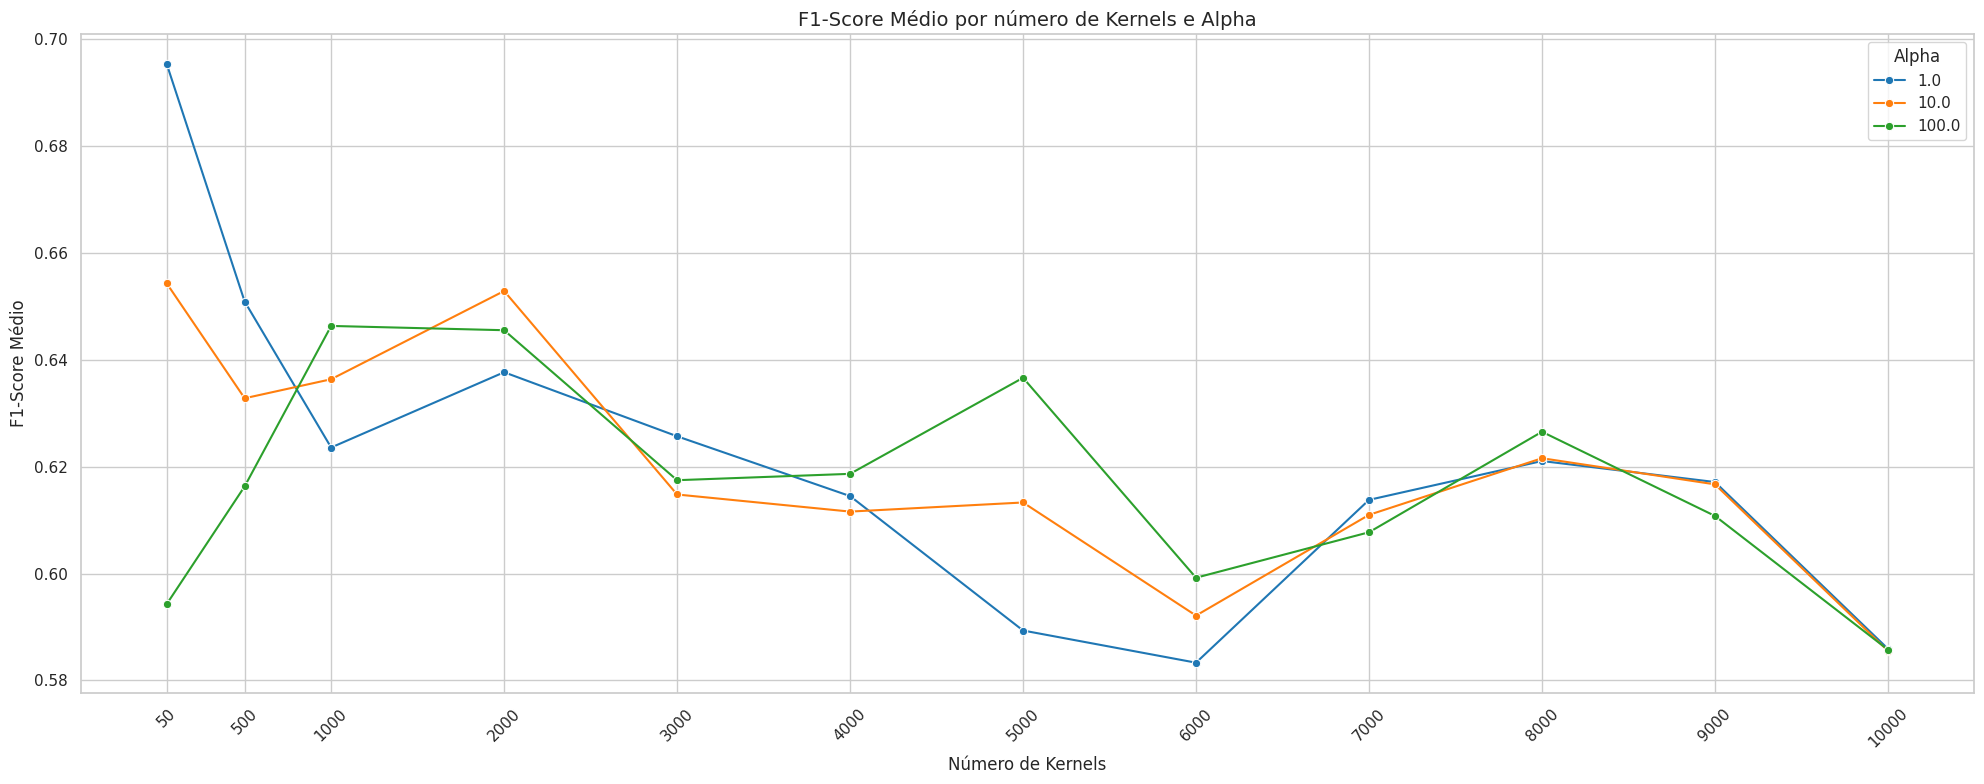

In [38]:
plot_line_chart(
    data=df_results,
    x_col='param_rocket__num_kernels',
    y_col='mean_test_f1',
    hue_col='param_ridge__alpha',
    title='F1-Score Médio por número de Kernels e Alpha',
    xlabel='Número de Kernels',
    ylabel='F1-Score Médio',
    legend_title='Alpha',
    figsize=(20, 8),
    palette="tab10",    
    rotation=45
)


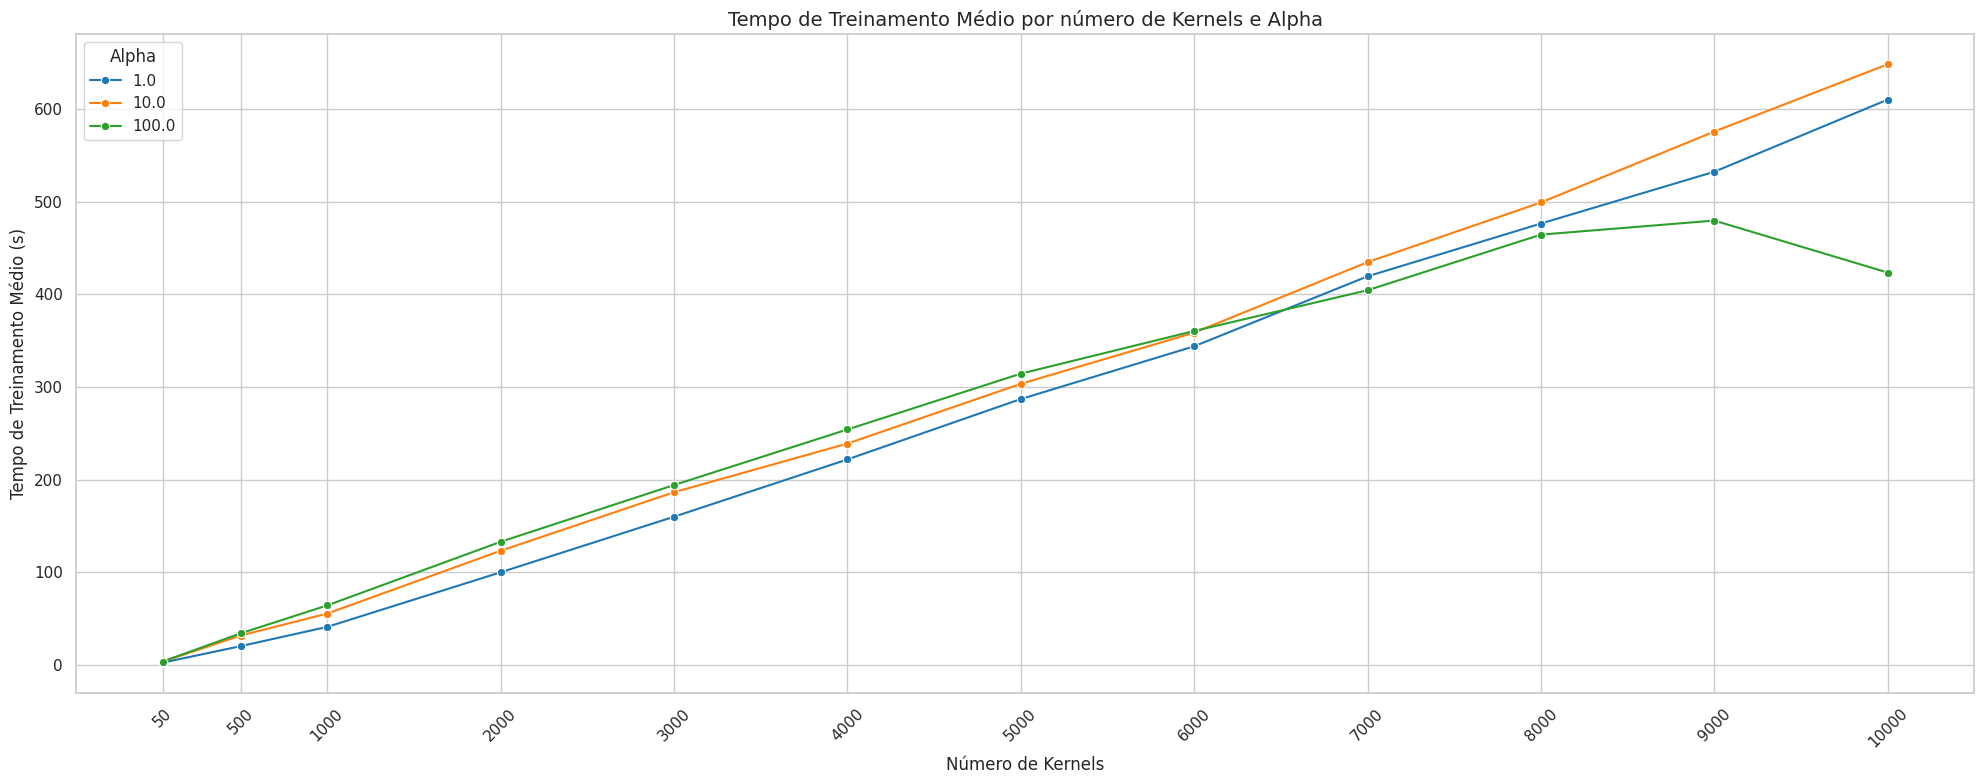

In [39]:
plot_line_chart(
    data=df_results,
    x_col='param_rocket__num_kernels',
    y_col='mean_fit_time',
    hue_col='param_ridge__alpha',
    title='Tempo de Treinamento Médio por número de Kernels e Alpha',
    xlabel='Número de Kernels',
    ylabel='Tempo de Treinamento Médio (s)',
    legend_title='Alpha',
    figsize=(20, 8),
    palette="tab10", 
    rotation=45
)